In [1]:
using Printf
using DelimitedFiles

In [46]:
@enum InterpolationType UPWIND LINEAR QUICK

struct CaseConfig 
    LX::Float64
    LY::Float64
    
    NUM_X_CELLS::Int64
    NUM_Y_CELLS::Int64

    NUM_GHOST_CELLS::Int64
    NUM_RK_STEPS::Int64

    NUM_TIME_STEPS::Int64
    TIME_STEPS_SIZE::Float64
end

In [124]:
mutable struct Cell
    CENTER_POS::Array{Float64,1}
    WEST_FACE_POS::Array{Float64,1}
    EAST_FACE_POS::Array{Float64,1}
    NORTH_FACE_POS::Array{Float64,1}
    SOUTH_FACE_POS::Array{Float64,1}

    X_SIZE::Float64
    Y_SIZE::Float64

    CENTER_VAL::Array{Float64,1}
    WEST_FACE_VAL::Float64
    EAST_FACE_VAL::Float64
    NORTH_FACE_VAL::Float64
    SOUTH_FACE_VAL::Float64

    WEST_FACE_UNITNORM::Array{Float64,1}
    EAST_FACE_UNITNORM::Array{Float64,1}
    NORTH_FACE_UNITNORM::Array{Float64,1}
    SOUTH_FACE_UNITNORM::Array{Float64,1}

    TOTAL_FLUX::Array{Float64,1}

    function Cell(px::Float64, py::Float64)
        this = new()
    
            this.CENTER_POS = [px, py]
    
        return this
    end
end


mutable struct RecMesh2D
    U_CELL::Array{Cell,2}
    
    function RecMesh2D(config::CaseConfig)
        this = new()
        
        px = map(x->compute_streching(x,x)*config.LX, range(0, 1, length=config.NUM_X_CELLS))
        py = map(x->compute_streching(x,x)*config.LY, range(0, 1, length=config.NUM_Y_CELLS))
    
        this.U_CELL = [ Cell(px[i],py[j])
                        for i = 1 : config.NUM_X_CELLS,
                            j = 1 : config.NUM_Y_CELLS ]
    
        return this
    end


    # ============================================
    # Compute Strech fun by Newton method
    # ============================================
    function compute_streching(x0::Float64, xn::Float64, K::Float64 =1.5, Beta::Float64 = 0.5,
                               e::Float64 = 0.001, iter_max::Int64 = 50)

        x_a = x0

        subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
        subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

        x_b = x_a-subs/subs_x
        iter_num=1

        while abs(x_a-x_b)>e
            iter_num = iter_num+1
            x_a = x_b
            subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
            subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

            x_b = x_a-subs/subs_x

            if iter_num>=iter_max
                return x_b
            end
        end

        return x_b
    end
end

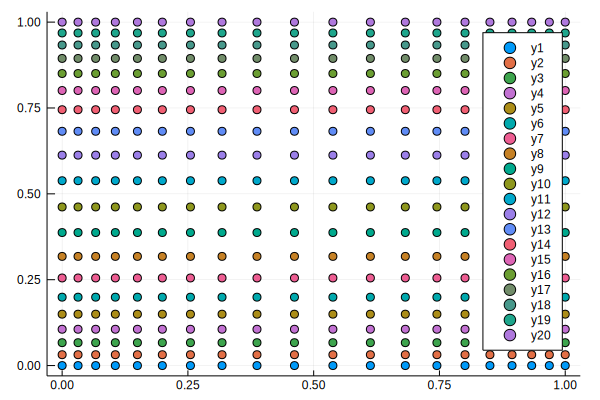

In [125]:
myconfig = CaseConfig(1, 1, 20, 20, 1, 1, 10, 0.01)
mymesh = RecMesh2D(myconfig)


CELLx = [ mymesh.U_CELL[i,j].CENTER_POS[1]
                for i = 1 : myconfig.NUM_X_CELLS,
                    j = 1 : myconfig.NUM_Y_CELLS ]

CELLy = [ mymesh.U_CELL[i,j].CENTER_POS[2]
                for i = 1 : myconfig.NUM_X_CELLS,
                    j = 1 : myconfig.NUM_Y_CELLS ]

scatter(CELLx,CELLy)

In [4]:
using Plots
plot(px, py)

compute_streching (generic function with 5 methods)

0.3689235119863878

In [54]:
function compute_streching(x0::Float64, xn::Float64, K::Float64 = 1.0, Beta::Float64 = 1.0,
                           e::Float64 = 0.001, iter_max::Int64 = 50)

    x_a = x0

    subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn
    subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

    x_b = x_a-subs/subs_x
    iter_num=1

    while abs(x_a-x_b)>e
        iter_num = iter_num+1
        x_a = x_b
        subs = Beta + (x_a-Beta)*exp(K*x_a*(x_a-1)) - xn

        subs_x = exp(K*x_a*(x_a-1))*(K*(2*x_a-1)*(x_a-Beta)+1)

        x_b = x_a-subs/subs_x

        if iter_num>=iter_max
            return x_b
        end
    end

    return x_b
end

compute_streching (generic function with 5 methods)

In [66]:
py = map(x->compute_streching(x,x,1.0,0.5), range(0, 1, length=10))

10-element Array{Float64,1}:
 0.0                
 0.08104197985137711
 0.17837699273961652
 0.29481788052307506
 0.4290237089215412 
 0.5709762910784587 
 0.7051821194769248 
 0.8216230072603835 
 0.9189580201486228 
 1.0                

In [62]:
using Plots
plot(px, py)

BoundsError: BoundsError: attempt to access 10-element Array{Float64,1} at index [1:50]